## Cristiano Nicolau - 108536

In [18]:
import os
if not os.path.exists("_input/fma_metadata"):
    os.makedirs("_input", exist_ok=True)
    !curl -o _input/fma_metadata.zip https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
    !unzip _input/fma_metadata.zip -d _input

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


Ex c1

In [20]:
features_df = pd.read_csv("_input/fma_metadata/features.csv", skiprows=3, index_col=0)
features_df.head(3)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 509,Unnamed: 510,Unnamed: 511,Unnamed: 512,Unnamed: 513,Unnamed: 514,Unnamed: 515,Unnamed: 516,Unnamed: 517,Unnamed: 518
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861


In [21]:
tracks_df = pd.read_csv("_input/fma_metadata/tracks.csv", header=[0, 1], index_col=0)
tracks_df[("set", "subset")].value_counts()

(set, subset)
large     81574
medium    17000
small      8000
Name: count, dtype: int64

In [22]:
small_tracks = tracks_df[tracks_df[("set", "subset")] == "small"]
small_tracks.shape
features_small = features_df.loc[small_tracks.index]
features_small.shape

(8000, 518)

In [23]:
X = features_small.values
X = StandardScaler().fit_transform(X)

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
var_ratio = pca.explained_variance_ratio_ * 100

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
def cluster_stats(X, labels):
    stats = []
    for cluster_id in np.unique(labels):
        points = X[labels == cluster_id]
        n_points = points.shape[0]
        centroid = points.mean(axis=0)

        r2 = np.mean(np.sum((points - centroid) ** 2, axis=1))

        if n_points > 1:
            pairwise_sq_dists = pairwise_distances(points, metric='euclidean') ** 2
            d2 = np.sum(pairwise_sq_dists) / (n_points ** 2)
        else:
            d2 = 0.0

        density_r = n_points / r2 if r2 != 0 else 0
        density_d = n_points / d2 if d2 != 0 else 0

        stats.append({
            "cluster_id": int(cluster_id),
            "n_points": int(n_points),
            "r2": float(r2),
            "d2": float(d2),
            "density_r": float(density_r),
            "density_d": float(density_d)
        })
    return stats

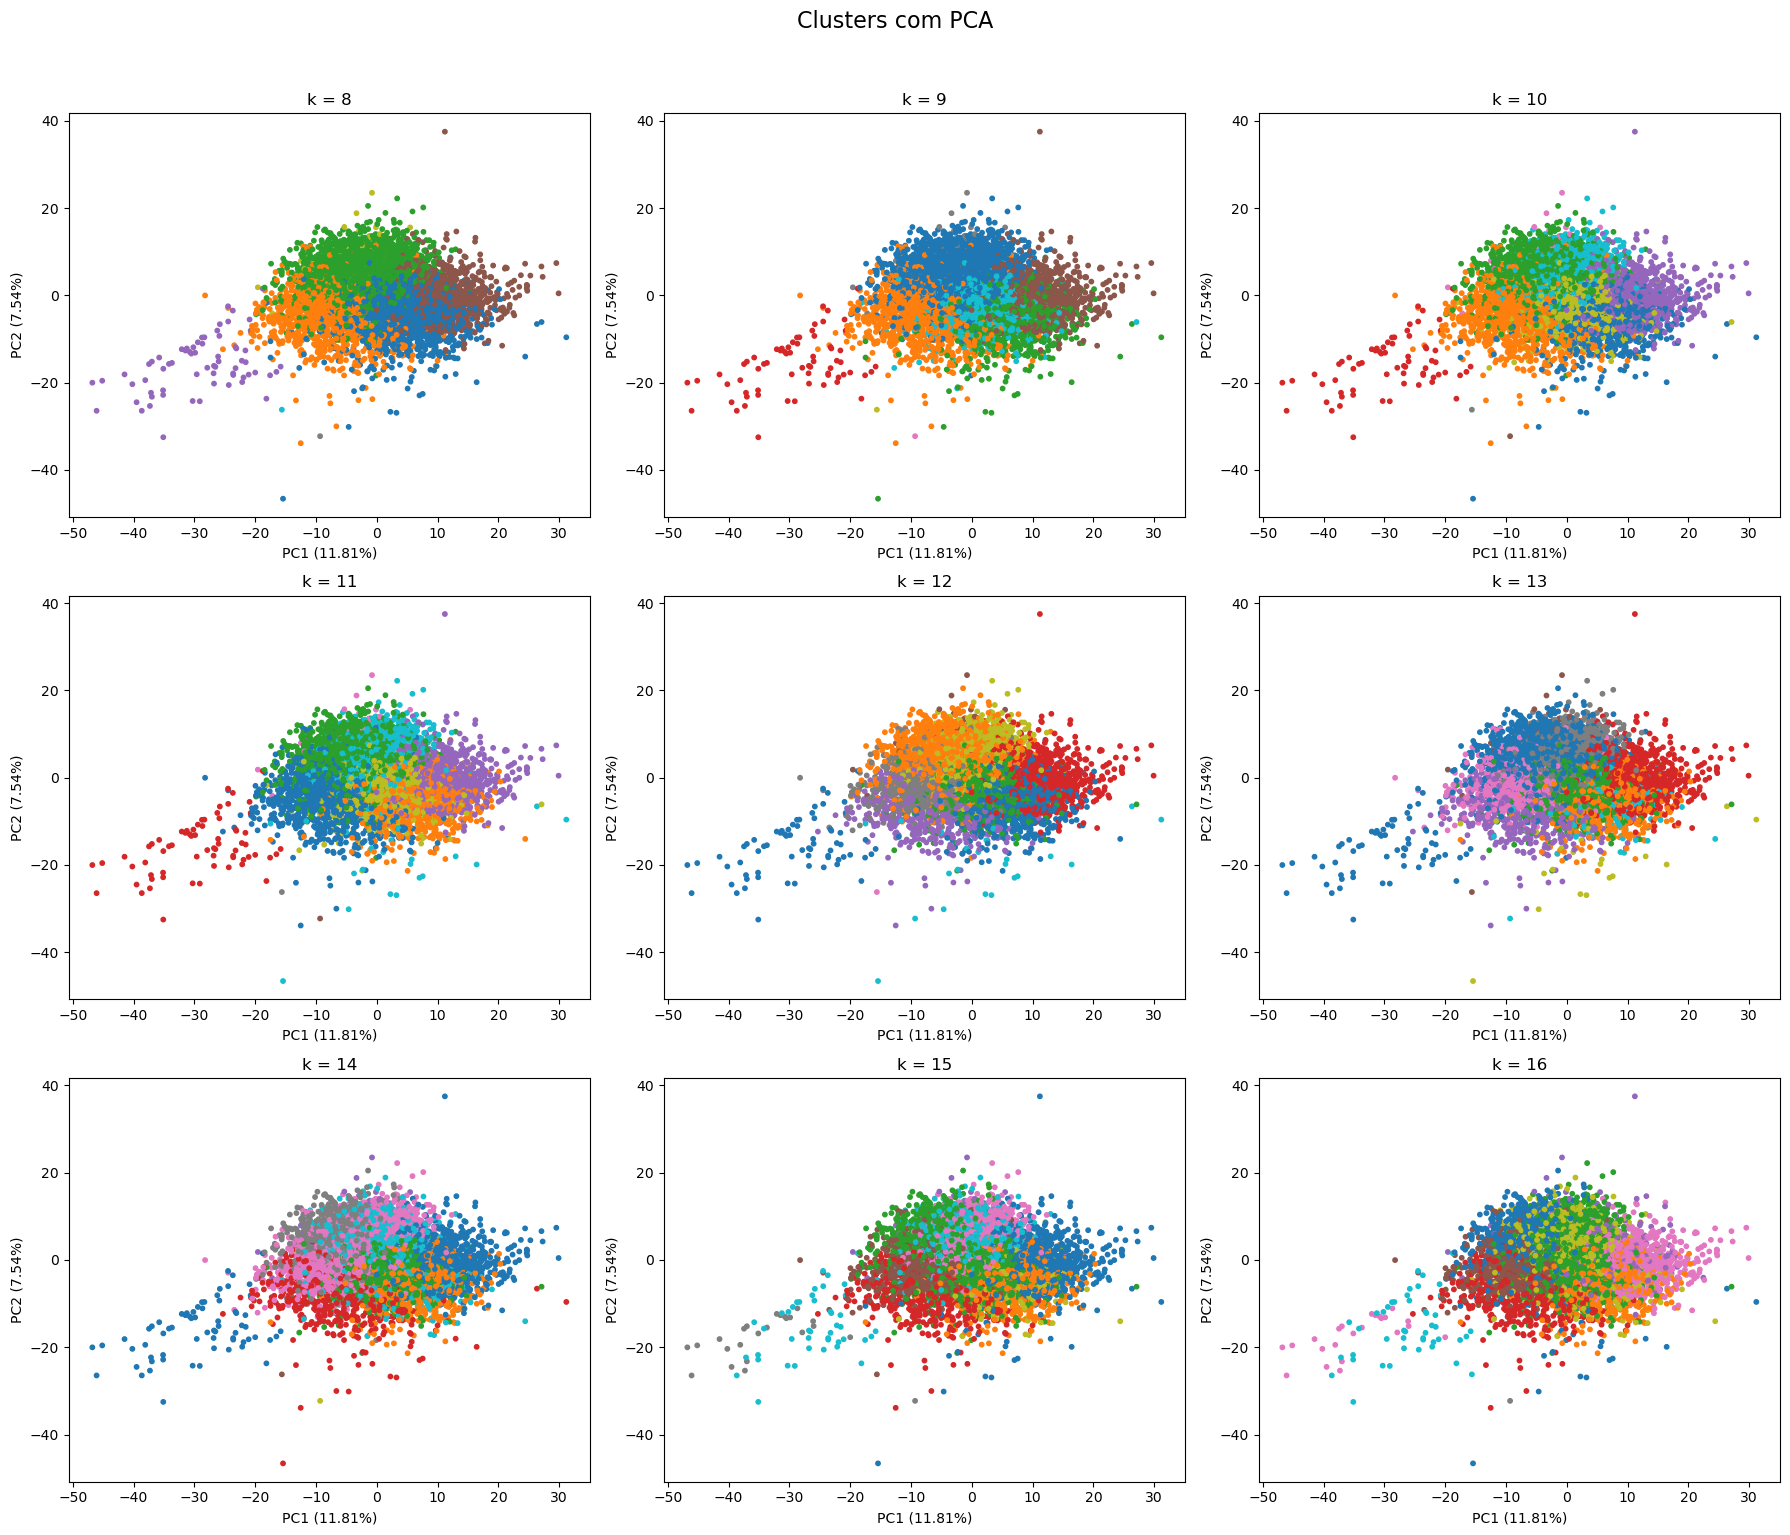

In [25]:
#  k [8 - 16]
results = {}
for i, k in enumerate(range(8, 17)):
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    stats = cluster_stats(X, labels)
    results[k] = stats

    # Visualização em PCA
    row, col = divmod(i, 3)
    ax = axes[row, col]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_title(f'k = {k}', fontsize=12)
    ax.set_xlabel(f'PC1 ({var_ratio[0]:.2f}%)')
    ax.set_ylabel(f'PC2 ({var_ratio[1]:.2f}%)')

fig.suptitle('Clusters com PCA', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [31]:
avg_densities = {}
for k, stats in results.items():
    density_r = np.mean([s["density_r"] for s in stats])
    density_d = np.mean([s["density_d"] for s in stats])
    avg_densities[k] = (density_r + density_d) / 2
    print(f"k = {k}: density_r = {density_r:.2f}, density_d = {density_d:.2f}, avg_density = {avg_densities[k]:.2f}")
best_k = max(avg_densities, key=avg_densities.get)
print(f"Best k: {best_k} with average density: {avg_densities[best_k]:.2f}")

k = 8: density_r = 2.36, density_d = 1.18, avg_density = 1.77
k = 9: density_r = 2.16, density_d = 1.08, avg_density = 1.62
k = 10: density_r = 1.97, density_d = 0.99, avg_density = 1.48
k = 11: density_r = 1.84, density_d = 0.92, avg_density = 1.38
k = 12: density_r = 1.70, density_d = 0.85, avg_density = 1.28
k = 13: density_r = 1.58, density_d = 0.79, avg_density = 1.18
k = 14: density_r = 1.49, density_d = 0.74, avg_density = 1.11
k = 15: density_r = 1.39, density_d = 0.69, avg_density = 1.04
k = 16: density_r = 1.31, density_d = 0.66, avg_density = 0.98
Best k: 8 with average density: 1.77


In [27]:
flat_results = []
for k, cluster_stats in results.items():
    for stat in cluster_stats:
        stat_with_k = {"k": k, **stat}
        flat_results.append(stat_with_k)

df_stats = pd.DataFrame(flat_results)
df_stats.to_csv("_output/exC1.csv", index=False)
df_stats.head()

,k,cluster_id,n_points,r2,d2,density_r,density_d
0,8,0,2195,553.148399,1106.296798,3.968194,1.984097
1,8,1,1424,420.992996,841.985992,3.382479,1.691240
2,8,2,3079,365.522800,731.045600,8.423551,4.211776
3,8,3,67,1636.147088,3272.294175,0.040950,0.020475
4,8,4,1159,384.194966,768.389932,3.016698,1.508349


In [28]:
with open("_output/exC1.txt", "w") as f:
    for k, stats in results.items():
        f.write(f"==== k = {k} ====\n")
        for s in stats:
            f.write(f"Cluster {s['cluster_id']} | n={s['n_points']} | r²={s['r2']:.2f} | d²={s['d2']:.2f} | dens_r={s['density_r']:.2f} | dens_d={s['density_d']:.2f}\n")
        f.write("\n")